In [1]:
!pip install split-folders

In [2]:
import splitfolders

In [3]:
path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

In [4]:
splitfolders.ratio(path, output = "TB Images", seed = 117, ratio = (0.7, 0.15, 0.15), group_prefix = None)


Copying files: 4200 files [00:38, 108.81 files/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
datagen = ImageDataGenerator()

In [7]:
img_width = 224
img_height = 224

In [8]:
splitted_dataset_path = "/kaggle/working/TB Images"

In [9]:
Train_generator = datagen.flow_from_directory(
    "/kaggle/working/TB Images/train",
    target_size=(img_height, img_width),
    batch_size=16
)

Test_generator = datagen.flow_from_directory(
    "/kaggle/working/TB Images/test",
    target_size=(img_height, img_width),
    batch_size=16
)

val_generator = datagen.flow_from_directory(
    "/kaggle/working/TB Images/val",
    target_size=(img_height, img_width),
    batch_size=16
)

Found 2939 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
Found 630 images belonging to 2 classes.


In [10]:
from tensorflow import keras

In [11]:
normalizer = keras.layers.Rescaling(scale=1/255)

In [12]:
input_shape = (img_width, img_height, 3)

dense_net = keras.applications.DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)

for layer in dense_net.layers:
     layer.trainable = False

51877672/51877672 [==============================] - 0s 0us/step


In [13]:
model = keras.Sequential([
    keras.Input(shape=(224,224,3)),
    normalizer,
    dense_net,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation = "softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 256)               20873472  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,516,866
Trainable params: 20,873,986
No

In [14]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=2, 
                                               verbose=1)
mc = keras.callbacks.ModelCheckpoint ('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(Train_generator, epochs=3, validation_data=val_generator, callbacks=[early_stopping, mc])

Epoch 1/3
184/184 [==============================] - 58s 221ms/step - loss: 1.3922 - accuracy: 0.9500 - val_loss: 0.0293 - val_accuracy: 0.9952
Epoch 2/3
184/184 [==============================] - 34s 183ms/step - loss: 0.0655 - accuracy: 0.9857 - val_loss: 0.1016 - val_accuracy: 0.9746
Epoch 3/3
184/184 [==============================] - 35s 191ms/step - loss: 0.0628 - accuracy: 0.9854 - val_loss: 0.0278 - val_accuracy: 0.9937


In [16]:
model.evaluate(Test_generator)

40/40 [==============================] - 8s 190ms/step - loss: 0.0212 - accuracy: 0.9921


[0.02118581533432007, 0.9920760989189148]

In [17]:
best_model = keras.models.load_model("best_model.h5")

In [18]:
best_model.evaluate(Test_generator)

40/40 [==============================] - 9s 147ms/step - loss: 0.0212 - accuracy: 0.9921


[0.02118581533432007, 0.9920760989189148]

In [19]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

# Define a function to predict if an image is "Normal" or "Tuberculosis"
def predict(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))  # Resize the image to the required dimensions
    img = img.convert("RGB")  # Ensure the image has 3 channels (RGB)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make the prediction using the loaded model
    prediction = best_model.predict(img)[0]

    # Define class labels (assuming 0 for normal and 1 for tuberculosis)
    class_names = ["Normal", "Tuberculosis"]

    # Get the class label with the highest probability
    predicted_class = class_names[np.argmax(prediction)]
    
    # Return the predicted class label
    return predicted_class

# Example usage:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1050.png'  # Replace with the path to your image
predicted_class = predict(image_path)
print("Predicted Class:", predicted_class)


1/1 [==============================] - 4s 4s/step
Predicted Class: Normal


1/1 [==============================] - 0s 37ms/step


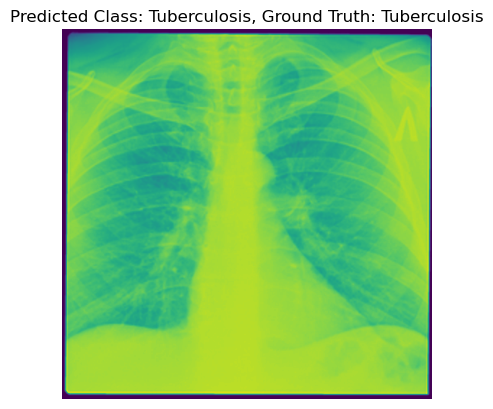

In [20]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to predict if an image is "Normal" or "Tuberculosis" and display the image
def predict_and_display(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))  # Resize the image to the required dimensions
    img = img.convert("RGB")  # Ensure the image has 3 channels (RGB)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make the prediction using the loaded model
    prediction = best_model.predict(img)[0]

    # Define class labels (assuming 0 for normal and 1 for tuberculosis)
    class_names = ["Normal", "Tuberculosis"]

    # Get the predicted class label
    predicted_class = class_names[np.argmax(prediction)]

    # Determine the ground truth class based on the directory structure of the image path
    ground_truth = os.path.basename(os.path.dirname(image_path))

    # Display the image, predicted class label, and ground truth
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {predicted_class}, Ground Truth: {ground_truth}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png'  # Replace with the path to your image
predict_and_display(image_path)


1/1 [==============================] - 0s 36ms/step


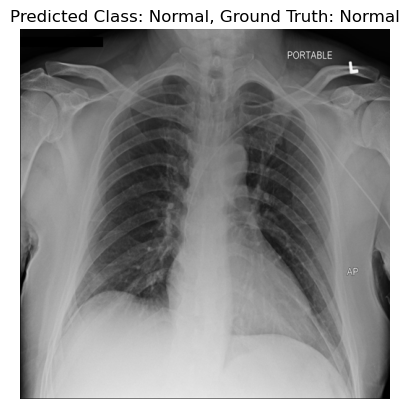

In [21]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to predict if an image is "Normal" or "Tuberculosis" and display the image
def predict_and_display(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))  # Resize the image to the required dimensions
    img = img.convert("RGB")  # Ensure the image has 3 channels (RGB)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make the prediction using the loaded model
    prediction = best_model.predict(img)[0]

    # Define class labels (assuming 0 for normal and 1 for tuberculosis)
    class_names = ["Normal", "Tuberculosis"]

    # Get the predicted class label
    predicted_class = class_names[np.argmax(prediction)]

    # Determine the ground truth class based on the directory structure of the image path
    ground_truth = os.path.basename(os.path.dirname(image_path))

    # Display the image, predicted class label, and ground truth
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {predicted_class}, Ground Truth: {ground_truth}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1004.png'  # Replace with the path to your image
predict_and_display(image_path)


1/1 [==============================] - 0s 37ms/step


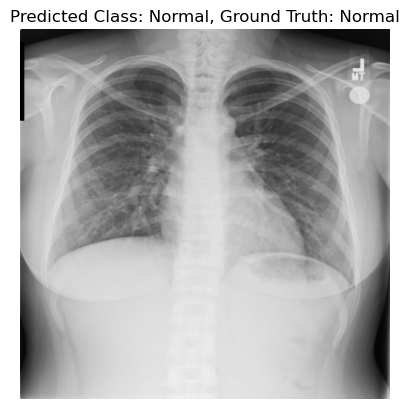

In [22]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to predict if an image is "Normal" or "Tuberculosis" and display the image
def predict_and_display(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))  # Resize the image to the required dimensions
    img = img.convert("RGB")  # Ensure the image has 3 channels (RGB)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make the prediction using the loaded model
    prediction = best_model.predict(img)[0]

    # Define class labels (assuming 0 for normal and 1 for tuberculosis)
    class_names = ["Normal", "Tuberculosis"]

    # Get the predicted class label
    predicted_class = class_names[np.argmax(prediction)]

    # Determine the ground truth class based on the directory structure of the image path
    ground_truth = os.path.basename(os.path.dirname(image_path))

    # Display the image, predicted class label, and ground truth
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {predicted_class}, Ground Truth: {ground_truth}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1013.png'  # Replace with the path to your image
predict_and_display(image_path)


1/1 [==============================] - 0s 37ms/step


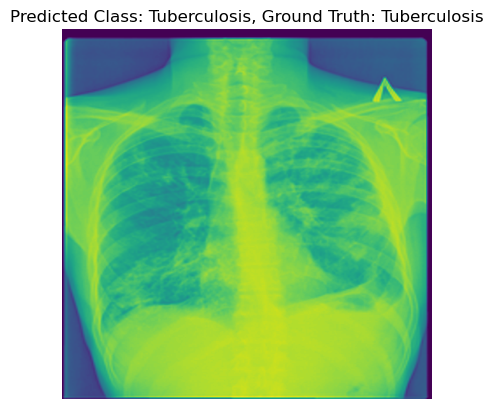

In [23]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to predict if an image is "Normal" or "Tuberculosis" and display the image
def predict_and_display(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))  # Resize the image to the required dimensions
    img = img.convert("RGB")  # Ensure the image has 3 channels (RGB)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make the prediction using the loaded model
    prediction = best_model.predict(img)[0]

    # Define class labels (assuming 0 for normal and 1 for tuberculosis)
    class_names = ["Normal", "Tuberculosis"]

    # Get the predicted class label
    predicted_class = class_names[np.argmax(prediction)]

    # Determine the ground truth class based on the directory structure of the image path
    ground_truth = os.path.basename(os.path.dirname(image_path))

    # Display the image, predicted class label, and ground truth
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {predicted_class}, Ground Truth: {ground_truth}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-125.png'  # Replace with the path to your image
predict_and_display(image_path)


1/1 [==============================] - 0s 39ms/step


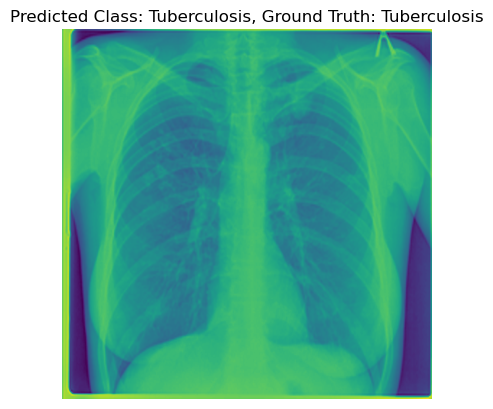

In [24]:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-130.png'  # Replace with the path to your image
predict_and_display(image_path)

1/1 [==============================] - 0s 36ms/step


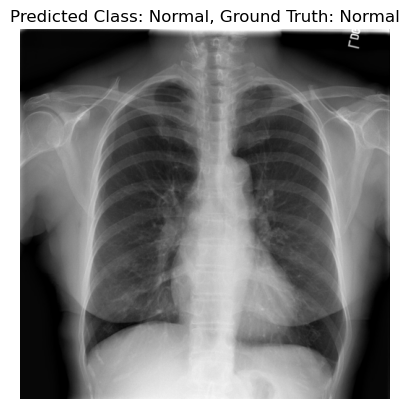

In [25]:
image_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1027.png'  # Replace with the path to your image
predict_and_display(image_path)

In [26]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('optimized_model.tflite', 'wb') as f:
    f.write(tflite_model)
